# **A Multi-Dimensional Approach to Player NBA Performance: Integrating Biometrics, Biographies, and Box Score Statistics**
**Fall 2024 Data Science Project**

Collaborators: Erik Lin, Constantin Fokoua, Luu Vo, Cole Drumgoole

Contributions: In this collaborative project, Elin (Erik Lin) serves as the leader, taking the initiative to provide valuable suggestions that guide the direction of the group’s work. His active participation and strong sense of responsibility make him a pivotal figure in the team's dynamic. He ensures that all team members are on the same page and promotes effective communication throughout the project. He contributed significantly in all sections, with focus on the ML Algorithm Training/Design by working on the random forest model and producing linear regression plots.

Constantin Fokoua plays a crucial role by presenting the final arguments and rationale needed to complete the project's concluding phases. He is instrumental in refining the project's concept and ensures that all submissions are organized and easily accessible for evaluation. He helped develop the project idea and located datasets to use for the analysis! In addition, he played an important role in data curation/collection and performing data analysis of the NBA player metrics.

Cole contributes significantly by carefully reviewing the project during its development. He is tasked with evaluating various components of the work, identifying errors, and providing constructive feedback. His attention to detail plays an essential role in ensuring the quality and accuracy of the project's final output. He contributed significantly to Data Analysis and Result Analysis by performing statistical tests and interpreting the meaning. In addition, he focused on adding relevant information to each section of the project and adjusting formatting to make sure all sections were completed.

Lastly, Luu Vo handles the critical task of summarizing the collaborative content created by the team. He meticulously fixes errors, addresses any formatting issues, and enriches the segments prepared by his teammates with additional relevant information. He contributed to significantly to dataset curation, analysis, and the final report curation by preparing the data for analysis and organizing the data. Together, the team works cohesively, with each member contributing their strengths to achieve a successful outcome.

---
# **Introduction**

Integrating NBA player biometrics—such as height and weight—with personal biographical data like age, nationality, and years of experience, alongside in-depth box score statistics—including points scored, rebounds, assists, steals, blocks, and turnovers—creates a rich, multi-dimensional portrait of NBA player performance and potential. This holistic approach not only facilitates diverse analyses, enabling predictions regarding player success, but also helps to uncover the intricate relationships between physical characteristics and various playing styles. Furthermore, it sheds light on the reasons behind the exceptional skills exhibited by players from different nationalities, illustrating the global nature of the sport and the unique contributions from diverse backgrounds. Ultimately, this analysis aims to provide unique insights that could be used for recruiting, training, and maximizing player potential.

---


# **Data Collection and Curation**

In [1]:
# Importing Libraries

import pandas as pd
import matplotlib.pyplot as plt
from scipy import stats
from scipy.stats import ttest_ind
from scipy.stats import chi2_contingency
from scipy.stats import chisquare
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.model_selection import train_test_split, cross_val_score, KFold
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA
from sklearn.metrics import mean_squared_error, r2_score


### Dataset Sources

In the initial phases of our project, we generated a wide array of ideas and potential avenues for implementation. However, we quickly realized that access to relevant information was quite limited. After engaging in thoughtful discussions about the best direction to take, we ultimately decided to concentrate our research on NBA performance. This encompasses a comprehensive analysis that integrates three key components: biometrics, player biographies, and box score statistics. To facilitate our research, we have identified valuable resources from various websites, including https://www.kaggle.com/datasets/mharvnek/nba-team-stats-00-to-18 and https://www.kaggle.com/datasets/justinas/nba-players-data/data, which will provide us with the necessary data. These datasets provide us with information regarding individual NBA player performance and NBA team statistics over a period of time.

To bring our project to fruition, we will be utilizing the Python programming language, which is well-suited for data analysis and visualization. We plan to employ tools such as iPython and Jupyter Notebook for our development work. Jupyter Notebooks, in particular, offer an interactive coding environment that allows for the creation of documents that can contain live code, equations, visualizations, and narrative text. If you are not yet familiar with Jupyter Notebooks, I highly encourage you to take the time to learn more about them, as they will be instrumental in our project’s execution.



### Data Preprocessing

In [3]:
# Importing our data

nba_players = pd.read_csv('all_seasons.csv')
team_stats = pd.read_csv('nba_team_stats_00_to_23.csv')
team_pg_stats = pd.read_csv('nba_team_stats_playoffs_00_to_21.csv')

### Parsing and Cleaning Data (Converting Metrics, Missing/Duplicate Values)

In [4]:
# Converting Metrics

# covert height from cm to ft
nba_players['player_height_ft'] = round(nba_players['player_height'] / 2.54 / 12, 2)
# covert weight from kg to lb
nba_players['player_weight_lb'] = round(nba_players['player_weight'] * 2.204622622, 0)
# convert weight to int
nba_players['player_weight_lb'] = nba_players['player_weight_lb'].astype(int)

In [5]:
# Check for missing values

print("\nMissing Values in NBA Players Data:")
print(nba_players.isnull().sum())
print("\nMissing Values in NBA Team Stats Data:")
print(team_stats.isnull().sum())
print("\nMissing Values in NBA Team Playoff Stats Data:")
print(team_pg_stats.isnull().sum())


Missing Values in NBA Players Data:
Unnamed: 0              0
player_name             0
team_abbreviation       0
age                     0
player_height           0
player_weight           0
college              1854
country                 0
draft_year              0
draft_round             0
draft_number            0
gp                      0
pts                     0
reb                     0
ast                     0
net_rating              0
oreb_pct                0
dreb_pct                0
usg_pct                 0
ts_pct                  0
ast_pct                 0
season                  0
player_height_ft        0
player_weight_lb        0
dtype: int64

Missing Values in NBA Team Stats Data:
teamstatspk                 0
Team                        0
games_played                0
wins                        0
losses                      0
win_percentage              0
Min                         0
points                      0
field_goals_made            0
field_goals_atte

From the output, we can see that only the **college** column has missing values. This is because pandas intepreted most of the values as NaN instead of 'None'. We will replace these missing values with 'No College'. However, we will first do a hot deck imputation to see if we can fill in the missing values with the same player's college in a different season (some have None only in some seasons but not others e.g "Jay Scrubb").

There are 5 rows with no college mentioned at all (empty space). However, this can easily be fixed by hot deck imputation where we replace with values found in different seasons from the same player!

Below, we are going to correct some features in the dataset (convert age to int, convert draft_year to year, etc.) and perform the imputation processes by showing a before and after example.


In [6]:
# Correcting Features

# convert age from float to int
nba_players['age'] = nba_players['age'].astype(int)

# We'll convert draft_year from a str to a year by replacing undrafted w/ NaT
nba_players.loc[nba_players['draft_year'] == 'Undrafted', 'draft_year'] = pd.NaT
nba_players['draft_year'] = nba_players['draft_year'].apply(lambda x: pd.to_datetime(x, format='%Y'))

# We'll convert draft_round and draft_number from a str to a int by replacing undrafted w/ 0
nba_players['draft_round'] = nba_players['draft_round'].replace('Undrafted', 0)
nba_players['draft_round'] = nba_players['draft_round'].astype(int)
nba_players['draft_number'] = nba_players['draft_number'].replace('Undrafted', 0)
nba_players['draft_number'] = nba_players['draft_number'].astype(int)

# Column 'Unamed: 0' can be dropped as it is just an index and other redundant columns
nba_players = nba_players.drop(columns=['Unnamed: 0'])
team_stats = team_stats.drop(['teamstatspk'], axis=1)
team_pg_stats = team_pg_stats.drop(['teamstatspk'], axis=1)


##### Fixing Missing Values: Before and After

In [7]:
# Example BEFORE fixing missing values

print("\nExample of Missing College:")
nba_players[nba_players['player_name'] == 'Jay Scrubb']


Example of Missing College:


,player_name,team_abbreviation,age,player_height,player_weight,college,country,draft_year,draft_round,draft_number,...,ast,net_rating,oreb_pct,dreb_pct,usg_pct,ts_pct,ast_pct,season,player_height_ft,player_weight_lb
11234,Jay Scrubb,LAC,20,195.58,99.79024,,USA,2020-01-01,2,55,...,0.3,-2.8,0.022,0.14,0.217,0.458,0.015,2020-21,6.42,220
11834,Jay Scrubb,LAC,21,195.58,99.79024,NaN,USA,2020-01-01,2,55,...,0.4,6.9,0.016,0.10,0.188,0.486,0.095,2021-22,6.42,220
12798,Jay Scrubb,ORL,22,195.58,99.79024,John A. Logan,USA,2020-01-01,2,55,...,0.5,-28.5,0.000,0.30,0.151,0.825,0.056,2022-23,6.42,220


In [8]:
# Example AFTER fixing missing values

players_with_na_college = nba_players[nba_players['college'].isna()]

# EXPENSIVE OPERATION WARNING!
for index, row in players_with_na_college.iterrows():
  player_name = row['player_name']
  college = row['college']

  # if college is valid skip
  if college == college:
    continue

  # Find other occurrences of the same player where 'college' is valid
  valid_college = nba_players.loc[
      (nba_players['player_name'] == player_name) &
      (nba_players['college'].notna()) &
      (nba_players['college'].str.strip() != ''),
      'college'
  ]

  # If a valid college is found, update all occurrences of the player with the valid college
  if not valid_college.empty:
      nba_players.loc[nba_players['player_name'] == player_name, 'college'] = valid_college.iloc[0]

# now we replace remaining missing values with 'No College'
nba_players['college'] = nba_players['college'].fillna('No College')

print("\nExample After Fixing Missing College:")
nba_players[nba_players['player_name'] == 'Jay Scrubb']



Example After Fixing Missing College:


,player_name,team_abbreviation,age,player_height,player_weight,college,country,draft_year,draft_round,draft_number,...,ast,net_rating,oreb_pct,dreb_pct,usg_pct,ts_pct,ast_pct,season,player_height_ft,player_weight_lb
11234,Jay Scrubb,LAC,20,195.58,99.79024,John A. Logan,USA,2020-01-01,2,55,...,0.3,-2.8,0.022,0.14,0.217,0.458,0.015,2020-21,6.42,220
11834,Jay Scrubb,LAC,21,195.58,99.79024,John A. Logan,USA,2020-01-01,2,55,...,0.4,6.9,0.016,0.10,0.188,0.486,0.095,2021-22,6.42,220
12798,Jay Scrubb,ORL,22,195.58,99.79024,John A. Logan,USA,2020-01-01,2,55,...,0.5,-28.5,0.000,0.30,0.151,0.825,0.056,2022-23,6.42,220


##### Checking for duplicate values

In [24]:
# Check for duplicates

print("\nNumber of Duplicates in NBA Players Data:")
print(nba_players.duplicated().sum())
print("\nNumber of Duplicates in NBA Team Stats Data:")
print(team_stats.duplicated().sum())
print("\nNumber of Duplicates in NBA Team Playoff Stats Data:")
print(team_pg_stats.duplicated().sum())

# More in-depth (looking at set of columns that should be a primary key)
print("nba_players duplicates: " + str(len(nba_players[['player_name', 'team_abbreviation', 'season']].drop_duplicates()) != len(nba_players)))
print("team_stats duplicates: " + str(len(team_stats[['Team', 'season']].drop_duplicates()) != len(team_stats)))
print("team_pg_stats duplicates: " + str(len(team_pg_stats[['team', 'season']].drop_duplicates()) != len(team_pg_stats)))

# now our player data is clean
print(nba_players.isnull().sum())


Number of Duplicates in NBA Players Data:
0

Number of Duplicates in NBA Team Stats Data:
0

Number of Duplicates in NBA Team Playoff Stats Data:
0
nba_players duplicates: False
team_stats duplicates: False
team_pg_stats duplicates: False
player_name             0
team_abbreviation       0
age                     0
player_height           0
player_weight           0
college                 0
country                 0
draft_year           2358
draft_round             0
draft_number            0
gp                      0
pts                     0
reb                     0
ast                     0
net_rating              0
oreb_pct                0
dreb_pct                0
usg_pct                 0
ts_pct                  0
ast_pct                 0
season                  0
player_height_ft        0
player_weight_lb        0
dtype: int64


From this output, ignore draft_year null values - we converted "Undrafted" to NaT when we were correcting features!

In [25]:
# The first few rows of the nba_players dataset after our corrections!

nba_players.head()

,player_name,team_abbreviation,age,player_height,player_weight,college,country,draft_year,draft_round,draft_number,...,ast,net_rating,oreb_pct,dreb_pct,usg_pct,ts_pct,ast_pct,season,player_height_ft,player_weight_lb
0,Randy Livingston,HOU,22,193.04,94.800728,Louisiana State,USA,1996-01-01,2,42,...,2.4,0.3,0.042,0.071,0.169,0.487,0.248,1996-97,6.33,209
1,Gaylon Nickerson,WAS,28,190.50,86.182480,Northwestern Oklahoma,USA,1994-01-01,2,34,...,0.3,8.9,0.030,0.111,0.174,0.497,0.043,1996-97,6.25,190
2,George Lynch,VAN,26,203.20,103.418976,North Carolina,USA,1993-01-01,1,12,...,1.9,-8.2,0.106,0.185,0.175,0.512,0.125,1996-97,6.67,228
3,George McCloud,LAL,30,203.20,102.058200,Florida State,USA,1989-01-01,1,7,...,1.7,-2.7,0.027,0.111,0.206,0.527,0.125,1996-97,6.67,225
4,George Zidek,DEN,23,213.36,119.748288,UCLA,USA,1995-01-01,1,22,...,0.3,-14.1,0.102,0.169,0.195,0.500,0.064,1996-97,7.00,264


##### Organizing Data

Here, we are going to create a combined dataset that includes data from the nba_players and team_stats datasets to allow for an easier approach to our analysis. We are going to merge them on the 'season' column and display the new dataset.

In [26]:
# Merge datasets on 'season' column
nba_combined = pd.merge(nba_players, team_stats, how='left', on='season', suffixes=('_player', '_team'))

print("\nCombined Data:")
print(nba_combined.head())


Combined Data:
        player_name team_abbreviation  age  player_height  player_weight  \
0  Randy Livingston               HOU   22         193.04      94.800728   
1  Gaylon Nickerson               WAS   28         190.50      86.182480   
2      George Lynch               VAN   26         203.20     103.418976   
3    George McCloud               LAL   30         203.20     102.058200   
4      George Zidek               DEN   23         213.36     119.748288   

                 college country draft_year  draft_round  draft_number  ...  \
0        Louisiana State     USA 1996-01-01            2            42  ...   
1  Northwestern Oklahoma     USA 1994-01-01            2            34  ...   
2         North Carolina     USA 1993-01-01            1            12  ...   
3          Florida State     USA 1989-01-01            1             7  ...   
4                   UCLA     USA 1995-01-01            1            22  ...   

   defensive_rebounds  rebounds  assists  turnovers 

# **Exploratory Data Analysis**

We are going to begin our exploratory data analysis by examining our imported datasets and viewing their summary statistics.

In [27]:
# Statistics of NBA Players Dataset

print("\nNumber of Entries in NBA Players Data:", nba_players.shape[0])
print("Number of Features in NBA Players Data:", nba_players.shape[1])

season_range = nba_players['season'].unique()
print("\nRange of Seasons:", season_range.min(), "to", season_range.max())

unique_players = nba_players['player_name'].nunique()
print("Number of Unique Players:", unique_players)

unique_teams = nba_players['team_abbreviation'].nunique()
print("Number of Teams:", unique_teams)


Number of Entries in NBA Players Data: 12844
Number of Features in NBA Players Data: 23

Range of Seasons: 1996-97 to 2022-23
Number of Unique Players: 2551
Number of Teams: 36


In [28]:
# Variance of columns in nba_players dataset

numeric_cols = nba_players.select_dtypes(include=['int64', 'float64']).columns
variance = nba_players[numeric_cols].var()

print("\nVariance:")
print(variance)


Variance:
age                  18.828749
player_height        83.011965
player_weight       154.421085
draft_round           0.466794
draft_number        282.350096
gp                  629.252415
pts                  36.199156
reb                   6.139912
ast                   3.243024
net_rating          160.405369
oreb_pct              0.001878
dreb_pct              0.003908
usg_pct               0.002867
ts_pct                0.010348
ast_pct               0.008868
player_height_ft      0.089407
player_weight_lb    750.526734
dtype: float64


#### **Examining nba_players dataset** (NBA Players Stats from 1996 - 2022)

In [29]:
print("Columns: ")
print(nba_players.columns, "\n\n")

print("Column Types:")
print(nba_players.dtypes, "\n\n")

for column in nba_players.columns:
  print(nba_players[column].describe())
# Somethings to note:
# player_height is in cm, player_weight is in kg
# pts, reb, ast are averaged

# Somethings to note about the data:
# 'draft_year', 'draft_round', and 'draft_number' are type string b/c of value 'undrafted', can substitute undraft w/ missing placeholder (such as -1 for ints, 0000 for year)
# Column 'Unamed: 0' can be dropped as it is just an index
# age could be converted to type int
nba_players

Columns: 
Index(['player_name', 'team_abbreviation', 'age', 'player_height',
       'player_weight', 'college', 'country', 'draft_year', 'draft_round',
       'draft_number', 'gp', 'pts', 'reb', 'ast', 'net_rating', 'oreb_pct',
       'dreb_pct', 'usg_pct', 'ts_pct', 'ast_pct', 'season',
       'player_height_ft', 'player_weight_lb'],
      dtype='object') 


Column Types:
player_name                  object
team_abbreviation            object
age                           int64
player_height               float64
player_weight               float64
college                      object
country                      object
draft_year           datetime64[ns]
draft_round                   int64
draft_number                  int64
gp                            int64
pts                         float64
reb                         float64
ast                         float64
net_rating                  float64
oreb_pct                    float64
dreb_pct                    float64
usg_pct     

,player_name,team_abbreviation,age,player_height,player_weight,college,country,draft_year,draft_round,draft_number,...,ast,net_rating,oreb_pct,dreb_pct,usg_pct,ts_pct,ast_pct,season,player_height_ft,player_weight_lb
0,Randy Livingston,HOU,22,193.04,94.800728,Louisiana State,USA,1996-01-01,2,42,...,2.4,0.3,0.042,0.071,0.169,0.487,0.248,1996-97,6.33,209
1,Gaylon Nickerson,WAS,28,190.50,86.182480,Northwestern Oklahoma,USA,1994-01-01,2,34,...,0.3,8.9,0.030,0.111,0.174,0.497,0.043,1996-97,6.25,190
2,George Lynch,VAN,26,203.20,103.418976,North Carolina,USA,1993-01-01,1,12,...,1.9,-8.2,0.106,0.185,0.175,0.512,0.125,1996-97,6.67,228
3,George McCloud,LAL,30,203.20,102.058200,Florida State,USA,1989-01-01,1,7,...,1.7,-2.7,0.027,0.111,0.206,0.527,0.125,1996-97,6.67,225
4,George Zidek,DEN,23,213.36,119.748288,UCLA,USA,1995-01-01,1,22,...,0.3,-14.1,0.102,0.169,0.195,0.500,0.064,1996-97,7.00,264
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
12839,Joel Embiid,PHI,29,213.36,127.005760,Kansas,Cameroon,2014-01-01,1,3,...,4.2,8.8,0.057,0.243,0.370,0.655,0.233,2022-23,7.00,280
12840,John Butler Jr.,POR,20,213.36,86.182480,Florida State,USA,NaT,0,0,...,0.6,-16.1,0.012,0.065,0.102,0.411,0.066,2022-23,7.00,190
12841,John Collins,ATL,25,205.74,102.511792,Wake Forest,USA,2017-01-01,1,19,...,1.2,-0.2,0.035,0.180,0.168,0.593,0.052,2022-23,6.75,226
12842,Jericho Sims,NYK,24,208.28,113.398000,Texas,USA,2021-01-01,2,58,...,0.5,-6.7,0.117,0.175,0.074,0.780,0.044,2022-23,6.83,250


#### **Examining team_stats dataset** (Regular Season Stats from 2000 - 2023)

In [30]:
print("Columns: ")
print(team_stats.columns, "\n")

print("Column Types:")
print(team_stats.dtypes)

team_stats

Columns: 
Index(['Team', 'games_played', 'wins', 'losses', 'win_percentage', 'Min',
       'points', 'field_goals_made', 'field_goals_attempted',
       'field_goal_percentage', 'three_pointers_made',
       'three_pointers_attempted', 'three_point_percentage',
       'free_throws_made', 'free_throw_attempted', 'free_throw_percentage',
       'offensive_rebounds', 'defensive_rebounds', 'rebounds', 'assists',
       'turnovers', 'steals', 'blocks', 'blocks_attempted', 'personal_fouls',
       'personal_fouls_drawn', 'plus_minus', 'season'],
      dtype='object') 

Column Types:
Team                         object
games_played                  int64
wins                          int64
losses                        int64
win_percentage              float64
Min                           int64
points                        int64
field_goals_made              int64
field_goals_attempted         int64
field_goal_percentage       float64
three_pointers_made           int64
three_pointers_attem

,Team,games_played,wins,losses,win_percentage,Min,points,field_goals_made,field_goals_attempted,field_goal_percentage,...,rebounds,assists,turnovers,steals,blocks,blocks_attempted,personal_fouls,personal_fouls_drawn,plus_minus,season
0,Boston Celtics,82,64,18,0.780,3966,9887,3601,7396,48.7,...,3799,2207,979,557,538,304,1326,1416,930,2023-24
1,Denver Nuggets,82,57,25,0.695,3941,9418,3610,7279,49.6,...,3643,2415,1036,585,456,394,1489,1467,431,2023-24
2,Oklahoma City Thunder,82,57,25,0.695,3961,9847,3653,7324,49.9,...,3447,2223,1039,694,538,419,1545,1548,608,2023-24
3,Minnesota Timberwolves,82,56,26,0.683,3961,9264,3383,6974,48.5,...,3577,2184,1162,647,497,371,1544,1630,529,2023-24
4,LA Clippers,82,51,31,0.622,3941,9481,3473,7108,48.9,...,3523,2097,1078,640,413,384,1519,1537,269,2023-24
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
711,Atlanta Hawks,82,25,57,0.305,3946,7459,2876,6668,43.1,...,3518,1559,1368,634,387,513,1863,7,-427,2000-01
712,Vancouver Grizzlies,82,23,59,0.280,3956,7522,2870,6539,43.9,...,3325,1899,1291,586,359,476,1733,5,-470,2000-01
713,Washington Wizards,82,19,63,0.232,3936,7645,2833,6453,43.9,...,3386,1647,1391,630,383,511,1913,9,-547,2000-01
714,Golden State Warriors,82,17,65,0.207,3956,7584,2937,7175,40.9,...,3730,1788,1301,742,410,493,1727,6,-742,2000-01


### **Examining team_pg_stats** (Playoff Games Stats 2000-2021)

In [31]:
print("Columns: ")
print(team_pg_stats.columns, "\n")

print("Column Types:")
print(team_pg_stats.dtypes)

team_pg_stats

Columns: 
Index(['team', 'games_played', 'wins', 'losses', 'win_percentage', 'minutes',
       'points', 'field_goals_made', 'field_goals_attempted',
       'field_goal_percentage', 'three_pointers_made',
       'three_pointers_attempted', 'three_point_percentage',
       'free_throws_made', 'free_throw_attempted', 'free_throw_percentage',
       'offensive_rebounds', 'defensive_rebounds', 'rebounds', 'assists',
       'turnovers', 'steals', 'blocks', 'blocks_attempted', 'personal_fouls',
       'personal_fouls_drawn', 'plus_minus', 'season'],
      dtype='object') 

Column Types:
team                         object
games_played                  int64
wins                          int64
losses                        int64
win_percentage              float64
minutes                     float64
points                      float64
field_goals_made            float64
field_goals_attempted       float64
field_goal_percentage       float64
three_pointers_made         float64
three_pointers_a

,team,games_played,wins,losses,win_percentage,minutes,points,field_goals_made,field_goals_attempted,field_goal_percentage,...,rebounds,assists,turnovers,steals,blocks,blocks_attempted,personal_fouls,personal_fouls_drawn,plus_minus,season
0,Milwaukee Bucks,23,16,7,0.696,48.4,110.3,42.1,91.1,46.2,...,49.0,22.8,12.7,7.8,4.2,3.8,18.0,20.1,5.1,2020-21
1,Phoenix Suns,22,14,8,0.636,48.0,109.0,40.9,85.0,48.1,...,42.7,23.2,11.9,6.5,4.2,3.6,19.7,18.5,4.5,2020-21
2,Brooklyn Nets,12,7,5,0.583,48.4,112.5,40.7,86.2,47.2,...,42.6,22.6,11.6,7.1,4.8,6.2,21.2,18.6,6.3,2020-21
3,Philadelphia 76ers,12,7,5,0.583,48.0,116.3,42.5,85.8,49.6,...,44.7,24.9,12.8,8.0,6.2,3.8,23.0,23.8,7.5,2020-21
4,Atlanta Hawks,18,10,8,0.556,48.0,106.3,38.9,86.8,44.9,...,42.4,20.2,12.4,6.7,4.4,4.3,21.2,20.3,-1.5,2020-21
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
331,Minnesota Timberwolves,4,1,3,0.250,48.0,82.0,30.8,79.5,38.7,...,42.5,18.5,12.8,7.5,5.8,4.5,24.3,0.0,-6.5,2000-01
332,Orlando Magic,4,1,3,0.250,49.3,102.8,39.0,89.8,43.5,...,43.8,22.0,11.3,8.0,6.3,5.3,26.5,0.3,-5.8,2000-01
333,Phoenix Suns,4,1,3,0.250,48.0,88.5,34.0,89.5,38.0,...,44.3,21.3,13.8,9.8,5.8,5.3,23.5,0.0,-9.5,2000-01
334,Miami Heat,3,0,3,0.000,48.0,78.3,29.7,72.3,41.0,...,35.0,16.7,18.7,5.0,5.0,4.0,25.3,0.3,-22.3,2000-01


After examining the features in each dataset, we first want to do some last minute correcting and then dive in to finding the distribution of points per player!

In [32]:
# Converting appropriate columns to numeric types (if necessary)
nba_players['draft_year'] = pd.to_numeric(nba_players['draft_year'], errors='coerce')
nba_players['draft_number'] = pd.to_numeric(nba_players['draft_number'], errors='coerce')

# Handling any missing values by filling or dropping (for simplicity, filling with 0s for draft-related columns)
nba_players['draft_year'] = nba_players['draft_year'].fillna(0)
nba_players['draft_number'] = nba_players['draft_number'].fillna(0)

# Checking if there are missing values across all datasets
missing_all_seasons = nba_players.isnull().sum()
missing_team_stats = team_stats.isnull().sum()
missing_playoffs_stats = team_pg_stats.isnull().sum()

# Converting season columns to proper format
team_stats['season'] = team_stats['season'].astype(str)
team_pg_stats['season'] = team_pg_stats['season'].astype(str)

# Extracting statistical summaries
summary_all_seasons = nba_players.describe()
summary_team_stats = team_stats.describe()
summary_playoffs_stats = team_pg_stats.describe()

missing_all_seasons, missing_team_stats, missing_playoffs_stats

(player_name          0
 team_abbreviation    0
 age                  0
 player_height        0
 player_weight        0
 college              0
 country              0
 draft_year           0
 draft_round          0
 draft_number         0
 gp                   0
 pts                  0
 reb                  0
 ast                  0
 net_rating           0
 oreb_pct             0
 dreb_pct             0
 usg_pct              0
 ts_pct               0
 ast_pct              0
 season               0
 player_height_ft     0
 player_weight_lb     0
 dtype: int64,
 Team                        0
 games_played                0
 wins                        0
 losses                      0
 win_percentage              0
 Min                         0
 points                      0
 field_goals_made            0
 field_goals_attempted       0
 field_goal_percentage       0
 three_pointers_made         0
 three_pointers_attempted    0
 three_point_percentage      0
 free_throws_made            0

#### Calculating the Distribution of Points per Player (Number of Points vs Frequency of Players)

Mean Points per Player: 8.2
Maximum Points: 36.1
Most players score between 3.6 to 11.5 points (25th to 75th percentile).


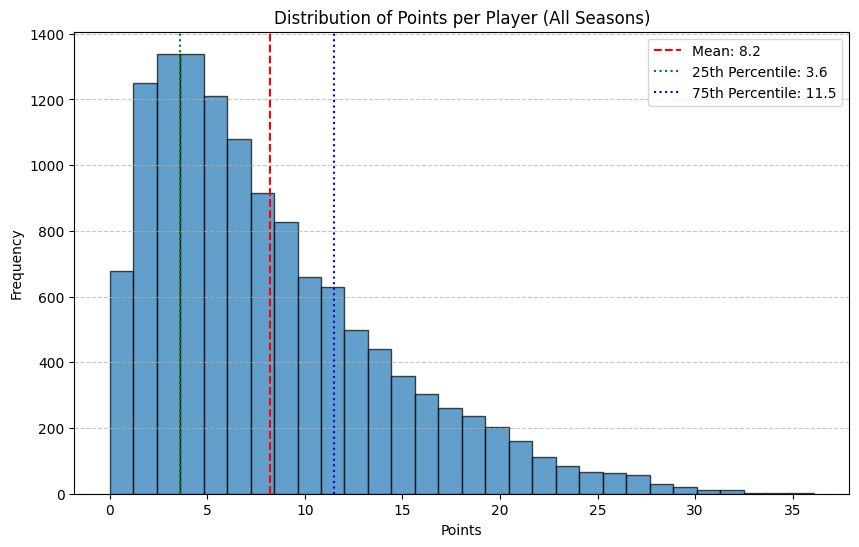

In [ ]:
# Calculate statistics
mean_points = nba_players['pts'].mean()
max_points = nba_players['pts'].max()
points_25th = nba_players['pts'].quantile(0.25)
points_75th = nba_players['pts'].quantile(0.75)

# Display statistics
print(f"Mean Points per Player: {mean_points:.1f}")
print(f"Maximum Points: {max_points}")
print(f"Most players score between {points_25th} to {points_75th} points (25th to 75th percentile).")

# Plot: Distribution of Points per Player
plt.figure(figsize=(10, 6))
plt.hist(nba_players['pts'], bins=30, edgecolor='black', alpha=0.7)
plt.axvline(mean_points, color='red', linestyle='dashed', linewidth=1.5, label=f'Mean: {mean_points:.1f}')
plt.axvline(points_25th, color='green', linestyle='dotted', linewidth=1.5, label=f'25th Percentile: {points_25th}')
plt.axvline(points_75th, color='blue', linestyle='dotted', linewidth=1.5, label=f'75th Percentile: {points_75th}')
plt.title('Distribution of Points per Player (All Seasons)')
plt.xlabel('Points')
plt.ylabel('Frequency')
plt.legend()
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.show()

#### Calculating the Distribution of Rebounds per Player

Mean Rebounds per Player: 3.6
Maximum Rebounds: 16.3
Most players grab between 1.8 to 4.7 rebounds (25th to 75th percentile).


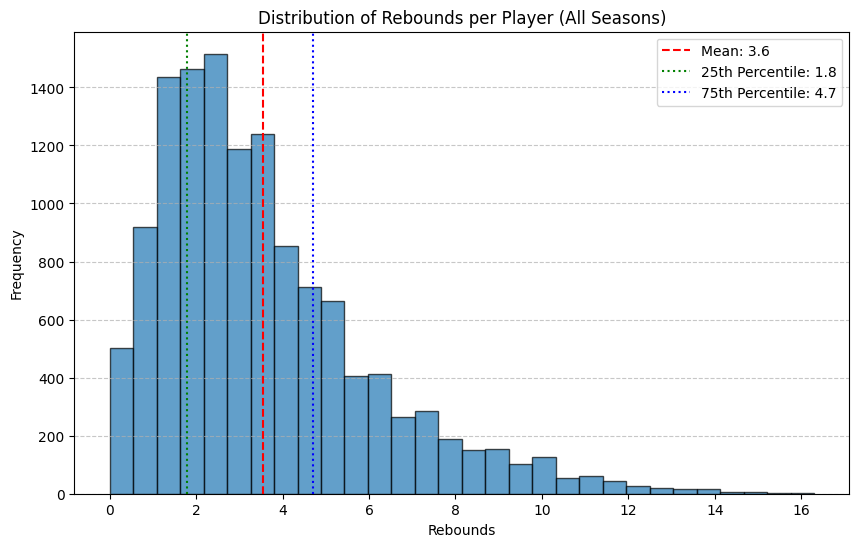

In [33]:
#Calculate statistics for rebounds
mean_rebounds = nba_players['reb'].mean()
max_rebounds = nba_players['reb'].max()
rebounds_25th = nba_players['reb'].quantile(0.25)
rebounds_75th = nba_players['reb'].quantile(0.75)

# Display statistics
print(f"Mean Rebounds per Player: {mean_rebounds:.1f}")
print(f"Maximum Rebounds: {max_rebounds}")
print(f"Most players grab between {rebounds_25th} to {rebounds_75th} rebounds (25th to 75th percentile).")

# Plot: Distribution of Rebounds per Player
plt.figure(figsize=(10, 6))
plt.hist(nba_players['reb'], bins=30, edgecolor='black', alpha=0.7)
plt.axvline(mean_rebounds, color='red', linestyle='dashed', linewidth=1.5, label=f'Mean: {mean_rebounds:.1f}')
plt.axvline(rebounds_25th, color='green', linestyle='dotted', linewidth=1.5, label=f'25th Percentile: {rebounds_25th}')
plt.axvline(rebounds_75th, color='blue', linestyle='dotted', linewidth=1.5, label=f'75th Percentile: {rebounds_75th}')
plt.title('Distribution of Rebounds per Player (All Seasons)')
plt.xlabel('Rebounds')
plt.ylabel('Frequency')
plt.legend()
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.show()

#### After viewing this data, we want to know: Is there correlation between Points, Rebounds, And Assists?

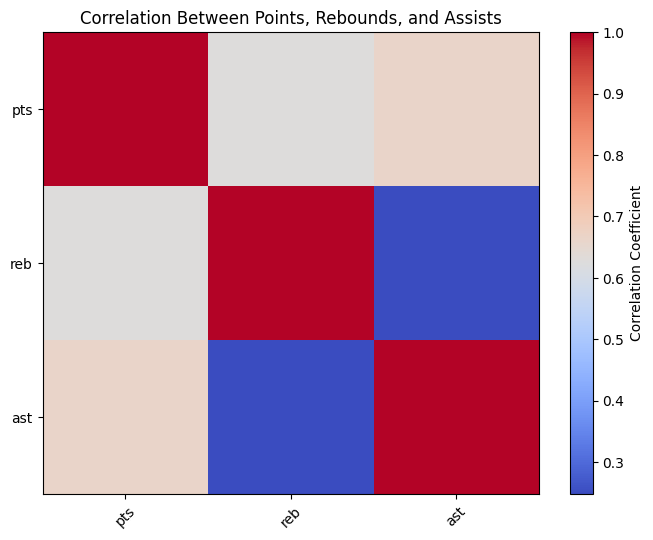

Correlation Matrix:
           pts       reb       ast
pts  1.000000  0.624509  0.664320
reb  0.624509  1.000000  0.247841
ast  0.664320  0.247841  1.000000


(count    12844.000000
 mean         8.212582
 std          6.016573
 min          0.000000
 25%          3.600000
 50%          6.700000
 75%         11.500000
 max         36.100000
 Name: pts, dtype: float64,
 count    12844.000000
 mean         3.558486
 std          2.477885
 min          0.000000
 25%          1.800000
 50%          3.000000
 75%          4.700000
 max         16.300000
 Name: reb, dtype: float64)

In [34]:
# Calculate the correlation matrix for points, rebounds, and assists
correlation_matrix = nba_players[['pts', 'reb', 'ast']].corr()

# Plot: Correlation Heatmap
plt.figure(figsize=(8, 6))
plt.imshow(correlation_matrix, cmap='coolwarm', interpolation='none', aspect='auto')
plt.colorbar(label='Correlation Coefficient')

# Set tick labels for heatmap
plt.xticks(range(len(correlation_matrix)), correlation_matrix.columns, rotation=45)
plt.yticks(range(len(correlation_matrix)), correlation_matrix.columns)

# Add title and grid
plt.title('Correlation Between Points, Rebounds, and Assists')
plt.grid(False)  # Avoid clutter with a heatmap grid

# Show the plot
plt.show()

# Display the correlation matrix in the console
print("Correlation Matrix:\n", correlation_matrix)

# Basic statistics on points and rebounds
points_stats = nba_players['pts'].describe()
rebounds_stats = nba_players['reb'].describe()

points_stats, rebounds_stats

#### **Correlation Analysis**

The correlation heatmap and matrix reveal the following:

* Points and Assists: High positive correlation (0.66) — players who score more tend to also accumulate more assists.
* Points and Rebounds: Moderate positive correlation (0.62) — players scoring high points often contribute to rebounds.
* Rebounds and Assists: Weak positive correlation (0.25) — indicating that these two metrics are not as strongly related.


This analysis suggests that **scorers** are often playmakers (with high assist stats) but there is a lesser relationship between assists and rebounding performance overall.

---

### Statistical Analysis and Hypothesis Testing

#### We will start by examining player biometrics.
#### **Using an ANOVA test, we want to see: Does a player's height give any advantage towards the amount of points they earn on average?**
* HO : Height does not affect how many points a player score on average

* HA : Height does influence a player's average scoring capability


The players are divided into three groups: small, average, and large. Players
that are less than the 33rd quartile are considered small, those taller than the
66th quartile are considered large, and the remaining are average.

ANOVA Test Results:
F_onewayResult(statistic=np.float64(20.170348854569863), pvalue=np.float64(1.7941545432241532e-09)) 



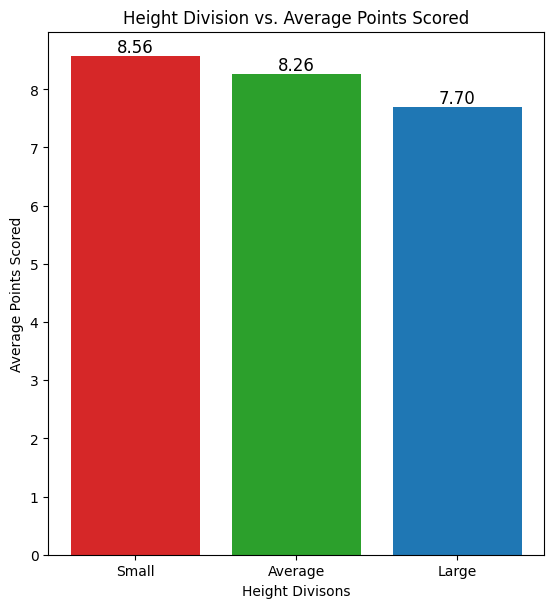


Our ANOVA Test resulted in a p-value of 1.79e-09 which is quite small. Suppose
we decided that our significance level, or alpha, is 0.05. Our p-value is much
lower than alpha, signaling that the chances of our results occurring due to
chance, assuming that the null hypothesis is true, is quite low. Therefore, we'll
conclude that height does have an impact on how many points a player earns on
average. However, we can't conclude between which groups is this difference observed.

Post-Hoc Test Results:
Tukey's HSD Pairwise Group Comparisons (95.0% Confidence Interval)
Comparison  Statistic  p-value  Lower CI  Upper CI
 (0 - 1)      0.301     0.041     0.010     0.592
 (0 - 2)      0.869     0.000     0.546     1.192
 (1 - 0)     -0.301     0.041    -0.592    -0.010
 (1 - 2)      0.567     0.000     0.257     0.878
 (2 - 0)     -0.869     0.000    -1.192    -0.546
 (2 - 1)     -0.567     0.000    -0.878    -0.257

Since we rejected the null hypothesis using the ANOVA Test, we'll explore
t

In [35]:
# Create categorical variable 'height_division' with three subcategories grouped by height
nba_players['height_division'] = pd.qcut(nba_players['player_height'], q=[0, 1/3, 2/3, 1], labels=["small", "average", "large"])

print("""
The players are divided into three groups: small, average, and large. Players
that are less than the 33rd quartile are considered small, those taller than the
66th quartile are considered large, and the remaining are average.
""")

# ANOVA Test
anova_rst = stats.f_oneway(nba_players[nba_players['height_division'] == 'small']['pts'],
               nba_players[nba_players['height_division'] == 'average']['pts'],
               nba_players[nba_players['height_division'] == 'large']['pts'])

print("ANOVA Test Results:")
print(anova_rst, "\n")

small_mean = nba_players[nba_players['height_division'] == 'small']['pts'].mean()
avg_mean = nba_players[nba_players['height_division'] == 'average']['pts'].mean()
large_mean = nba_players[nba_players['height_division'] == 'large']['pts'].mean()

colors=['tab:red', 'tab:green', 'tab:blue']
fig, ax = plt.subplots(1, 1)
bars = ax.bar(['Small', 'Average', 'Large'], [small_mean, avg_mean, large_mean],
       color=colors)
ax.set_title('Height Division vs. Average Points Scored')
ax.set_xlabel('Height Divisons')
ax.set_ylabel('Average Points Scored')
ax.bar_label(bars, fmt='{:,.2f}', fontsize=12)
plt.subplots_adjust(top=1.2)
plt.show()

print("""
Our ANOVA Test resulted in a p-value of 1.79e-09 which is quite small. Suppose
we decided that our significance level, or alpha, is 0.05. Our p-value is much
lower than alpha, signaling that the chances of our results occurring due to
chance, assuming that the null hypothesis is true, is quite low. Therefore, we'll
conclude that height does have an impact on how many points a player earns on
average. However, we can't conclude between which groups is this difference observed.""")

# Post-Hoc Test (Remove if unnecessary)
posthoc_rst = stats.tukey_hsd(nba_players[nba_players['height_division'] == 'small']['pts'],
                      nba_players[nba_players['height_division'] == 'average']['pts'],
                      nba_players[nba_players['height_division'] == 'large']['pts'])

print("\nPost-Hoc Test Results:")
print(posthoc_rst)

print("""Since we rejected the null hypothesis using the ANOVA Test, we'll explore
the direct differences in the mean with each group using a post-hoc test, more
specifically the Tukey Honestly Significant Difference Test. Within this test
each group's mean is directly compared with the other two groups (ex. small vs.
average, small vs. large, etc.) and a p-value is produced for each comparison.
From our observation, we found that all the p-values were lower than our alpha
(same alpha we had during the ANOVA Test) which means we can reject the null
hypothesis in all comparisons. This means that height does play a difference in a
player's average score across our simplified categorization of height.""")

### Continuing the pattern of looking at player biometrics, we want to see if the age of players has a significant effect on the average amount of points scored. This is associated with their years of experience. 
### **We will perform a two-tailed t-test to view this relationship. We will use a p-value of 0.05 for this experiment.**
* HO : Player's age has no effect on average points scored

* HA : Player's age does have an effect on average points scored


To conduct this t-test, the players are divided into two age groups based on the median age.
Players less than the median age are considered younger players, and players older
than the median age are considered older players. The mean points scored for these
player age groups will be compared using a t-test.



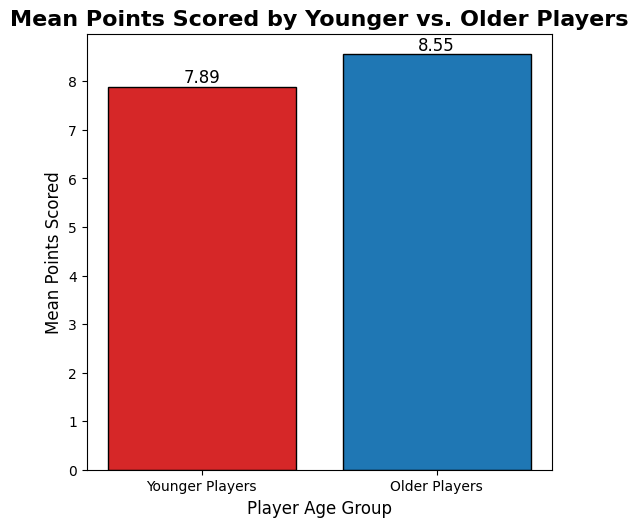

The p-value from the conducted t-test is shown below: 
3.587912704666241e-10

We can see that the p-value is 3.58e-10. With a significance level of 0.05, this p-value
indicates we have strong evidence to reject the null hypothesis since it is much lower than
the p-value. Thus, the results suggest that the age of players does have a significant effect
on the average number of points scored.


In [36]:
# Find median age of players
median_age = nba_players['age'].median()

# Separate younger and older players based on median age
young_pts = nba_players[nba_players['age'] <= median_age]['pts']
old_pts = nba_players[nba_players['age'] > median_age]['pts']

# Conduct t-test
t_stat, p_value = ttest_ind(young_pts, old_pts)

print("""
To conduct this t-test, the players are divided into two age groups based on the median age.
Players less than the median age are considered younger players, and players older
than the median age are considered older players. The mean points scored for these
player age groups will be compared using a t-test.
""")

# Calculate mean of each age group for graphing
young_mean = young_pts.mean()
old_mean = old_pts.mean()

# Customize Bar Graph details
colors = ['tab:red', 'tab:blue']
fig, ax = plt.subplots(figsize=(6, 4))

bars = plt.bar(['Younger Players', 'Older Players'], [young_mean, old_mean], color=colors, edgecolor='black')

plt.title('Mean Points Scored by Younger vs. Older Players', fontsize=16, weight='bold')
plt.ylabel('Mean Points Scored', fontsize=12)
plt.xlabel('Player Age Group', fontsize=12)

ax.bar_label(bars, fmt='{:,.2f}', fontsize=12)
plt.subplots_adjust(top=1.2)
plt.show()

print("""The p-value from the conducted t-test is shown below: """)
print(float(p_value))

print("""
We can see that the p-value is 3.58e-10. With a significance level of 0.05, this p-value
indicates we have strong evidence to reject the null hypothesis since it is much lower than
the p-value. Thus, the results suggest that the age of players does have a significant effect
on the average number of points scored.""")

### To finish our exploratory analysis of player biometrics, we will perform a **Chi-Square Test of Independence between weight and origin.**

Hypothesis:
* Null Hypothesis (H0): There is no association between weight category and origin; they are independent.
* Alternative Hypothesis (HA): There is an association between weight category and origin; they are not independent.

In [37]:
# Categorize Weights

weight_quantiles = nba_players['player_weight_lb'].quantile([0.33, 0.66])

def classify_weight(weight):
    if weight <= weight_quantiles.loc[0.33]:
        return 'Light'
    elif weight <= weight_quantiles.loc[0.66]:
        return 'Normal'
    else:
        return 'Heavy'

nba_players['weight_category'] = nba_players['player_weight_lb'].apply(classify_weight)

print("Distribution of Weight Categories:")
print(nba_players['weight_category'].value_counts())

Distribution of Weight Categories:
weight_category
Heavy     4362
Light     4254
Normal    4228
Name: count, dtype: int64


##### Create Origin Category

In [38]:
nba_players['origin'] = nba_players['country'].apply(lambda x: 'USA' if x == 'USA' else 'International')

print("\nDistribution of Player Origins:")
print(nba_players['origin'].value_counts())


Distribution of Player Origins:
origin
USA              10721
International     2123
Name: count, dtype: int64


##### Create Contingency Table for weight and origin

In [39]:
contingency_table = pd.crosstab(nba_players['weight_category'], nba_players['origin'])
print("\nContingency Table:")
print(contingency_table)


Contingency Table:
origin           International   USA
weight_category                     
Heavy                     1073  3289
Light                      474  3780
Normal                     576  3652


In [40]:
# Results!

chi2, p, dof, expected = chi2_contingency(contingency_table)

print("\nChi-Square Test Results:")
print("Chi-Square Statistic:", chi2)
print("Degrees of Freedom:", dof)
print("P-value:", p)


Chi-Square Test Results:
Chi-Square Statistic: 321.2176109182674
Degrees of Freedom: 2
P-value: 1.7720747769061882e-70


#### **Interpretation of Results**

The p-value is less than 0.05, which indicates that the null hypothesis can be rejected. Therefore, there is a significant relationship between the player's origin and their weight. This suggests that the player origin and weight category are not independent of each other. This is just one relationship that provides insight into NBA player biometrics!

#### Visualizing the Relationship

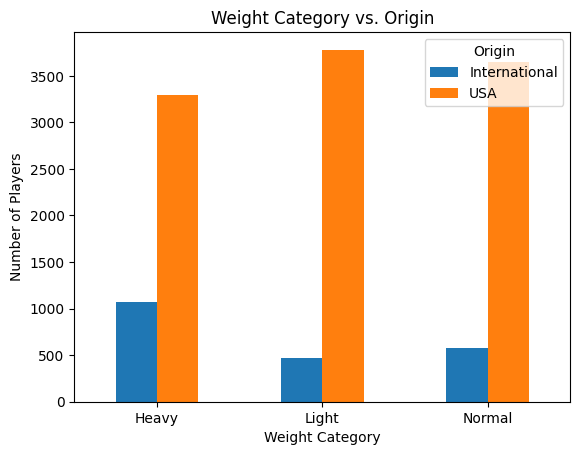

In [41]:
# Plot stacked bar chart
contingency_table.plot(kind='bar', color=['#1f77b4', '#ff7f0e'])
plt.title('Weight Category vs. Origin')
plt.xlabel('Weight Category')
plt.ylabel('Number of Players')
plt.legend(title='Origin')
plt.xticks(rotation=0)
plt.show()

# **Primary Analysis (ML Technique)**


### We will be using the **Random Forest Regression** model as our Machine Learning technique!

To observe the impact of each biometric feature in their scoring performance, we create a regressive random forest model with the following features:
* player_height_ft
* player_weight_lb
* age
* country

More information about random forest models can be found here: https://en.wikipedia.org/wiki/Random_forest

In [19]:
# print(nba_players.shape)
# Q1 = nba_players['gp'].quantile(0.25)
# Q3 = nba_players['gp'].quantile(0.75)
# IQR = Q3 - Q1
# lower_bound = Q1 - IQR * 1.5
# upper_bound = Q3 - IQR * 1.5
# nba_players = nba_players[(nba_players['gp'] >= lower_bound) & (nba_players['gp'] <= upper_bound)]
print(nba_players.columns)

Index(['player_name', 'team_abbreviation', 'age', 'player_height',
       'player_weight', 'college', 'country', 'draft_year', 'draft_round',
       'draft_number', 'gp', 'pts', 'reb', 'ast', 'net_rating', 'oreb_pct',
       'dreb_pct', 'usg_pct', 'ts_pct', 'ast_pct', 'season',
       'player_height_ft', 'player_weight_lb'],
      dtype='object')


In [15]:
# Preliminaries
random_state = 42

Before we create our random forest model, we'll have to perform some **feature manipulation**.

Of the four features we've selected, three of them are continuous. The only one that is categorical would be 'country'. To make our categorical variable suitable for regressive random forest model, we apply one hot encoding (For more info: https://www.geeksforgeeks.org/ml-one-hot-encoding/) to make binary classifications.

With the newly created features from the one hot encoding, we would have to remove some trivial features. As a result, we opted to create a new class 'Other' for players from rare countries.

Before we perform our last step of feature engineering, we split our data into a training and testing dataset. We train our model using our training set and evaluate its performance using our test set.

Lastly, to avoid having one feature dominate the others, we perform Z-score normalization using StandardScaler (https://scikit-learn.org/dev/modules/generated/sklearn.preprocessing.StandardScaler.html). This'll make our features converge and be scaled based on their respective standard deviation.

In [16]:
# Feature Extraction (Relevant Features: [player_height, player_weight, age, country], Target Variable: pts)
def feature_extraction(features, target, df = nba_players):
  X = df.drop(columns=[col for col in df.columns if col not in features])
  y = df[target]
  return X, y

X_nba_players, Y_nba_players = feature_extraction(['player_height_ft', 'player_weight_lb', 'age', 'country'], 'pts');

# Avoiding sparse datapoints by combining low-countries to 'Other'
small_sample_countries = X_nba_players['country'].value_counts()[X_nba_players['country'].value_counts().values < 30]
X_nba_players['country'] = X_nba_players['country'].apply(lambda x: 'Other' if x in small_sample_countries else x)

# Perform One Hot Encoding
X_nba_players = pd.get_dummies(X_nba_players, columns=['country'])

# Split into train/test set
X_train, X_test, y_train, y_test = train_test_split(X_nba_players, Y_nba_players, test_size=0.2, random_state=random_state)

# Standardizing nba_players
normalizer = StandardScaler()
X_train_scaled = normalizer.fit_transform(X_train)
X_train_scaled = pd.DataFrame(data=X_train_scaled, columns=X_train.columns)
X_test_scaled = normalizer.transform(X_test)
X_test_scaled = pd.DataFrame(data=X_test_scaled, columns=X_test.columns)

Now that our dataset has undergone feature engineering and being split. It's time to train our regressing random forest model. During our training phase, we perform cross validation to observe our model's predictive ability using what is known as K-Fold cross validation (https://scikit-learn.org/1.5/modules/cross_validation.html).

This allows us to better understand the performance of our model by testing it across a different training set and validation set and averaging their results!

In [17]:
RF_model = RandomForestRegressor(random_state=random_state)

# Validating the model
kf = KFold(n_splits=5, shuffle=True, random_state=random_state)
score = cross_val_score(RF_model, X_train_scaled, y_train, cv=kf, scoring='r2')
print(f'Mean: {score.mean()}, Standard Deviation: {score.std()}')

Mean: -0.0419981450456441, Standard Deviation: 0.015013687139105543


* Definition: $R^2$ measures the proportion of variance in the dependent variable (e.g., scoring performance) that can be explained by the independent variables (e.g., height, weight, age, and country).
* Interpretation:  
    * $R^2 = 1$ The model perfectly explains all variability in the data. 
    * $R^2 = 0$ The model does not explain any variability; it’s no better than using the mean value.
    * $R^2 < 0$ The model performs worse than a horizontal line (mean prediction). 
    * A negative $R^2$ indicates that the model is poorly suited for the data and performs worse than a simple baseline model (e.g., always predicting the mean of the target variable). 

By training and evaluating the model using cross-validation and $R^2$, we aim to: 
* Understand how well the features predict scoring performance. 
* Identify potential issues (e.g., poor feature selection or need for hyperparameter tuning) and refine the model accordingly.”

Using $R^2$, a evaluator for regression models (https://www.investopedia.com/terms/r/r-squared.asp), we observe that our cross validation outputs a negative $R^2$ value. Typically, $R^2$ can fall between 0 to 1, with 1 telling us that our model shows the relationship between our features and target very well, while 0 means poorly.

A negative $R^2$ value is possible and it indicates that our model performance is worse than a horizontal line.

In the context of our random forest model, there are some possible explanation towards the poor performance.
1. The hyperparameters we started off with lead to overfitting/underfitting (https://www.geeksforgeeks.org/underfitting-and-overfitting-in-machine-learning/)
2. There were somethings that we missed during our feature extraction
3. There is no relationship between a player's biometrics and their scoring capabilities

### **Hyperparameter Tuning**
To see whether our hyperparameters need tuning, we'll test a variety a range of hyperparameters and see which one gives us the best $R^2$ score.

When it comes to a random forest model, there are a couple of hyperparameters to consider:
* `n_estimators`
* `max_depth`
* `min_samples_split`
* `min_samples_leaf`
* `max_features`
* `max_samples`

We'll not be adjusting all these parameters because some have less impact than others. We'll focus on the main two: `n_estimators` and `max_depth`
<center>$\color{red}{\text{DO NOT RUN ANY OF THE FOLLOWING UNLESS YOU HAVE A SUPER COMPUTER, WHICH I DO NOT}}$</center>


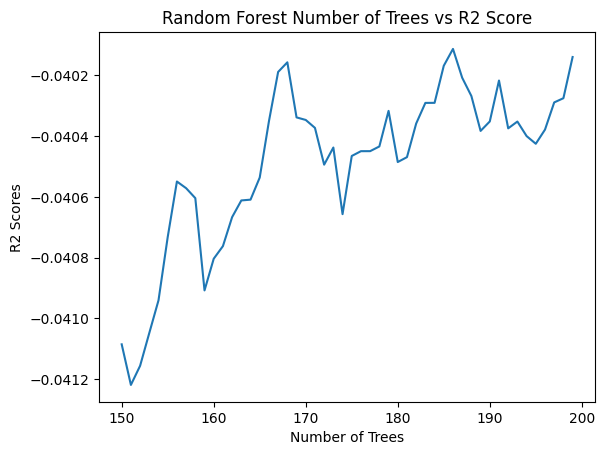

Best number of trees to use is 186 with R^2 score of -0.04011248069889497


In [18]:
# Number of Trees

kf = KFold(n_splits=5, shuffle=True, random_state=random_state)
num_trees = range(150, 200)
rsts = []
best_num_trees = 0
best_r2 = 0

for num in num_trees:
  rf_num_tree_model = RandomForestRegressor(n_estimators=num, random_state=random_state, n_jobs=-1)
  score = cross_val_score(rf_num_tree_model, X_train_scaled, y_train, cv=kf, scoring='r2', n_jobs=-1)
  rsts.append((num, score.mean()))
  best_so_far = max(rsts, key = lambda rst: rst[1])
  best_num_trees = best_so_far[0]
  best_r2 = best_so_far[1]


r2_scores = [x[1] for x in rsts]
trees = [x[0] for x in rsts]
plt.plot(trees, r2_scores)
plt.xlabel('Number of Trees')
plt.ylabel('R2 Scores')
plt.title('Random Forest Number of Trees vs R2 Score')
plt.show()

print(f'Best number of trees to use is {best_num_trees} with R^2 score of {best_r2}')

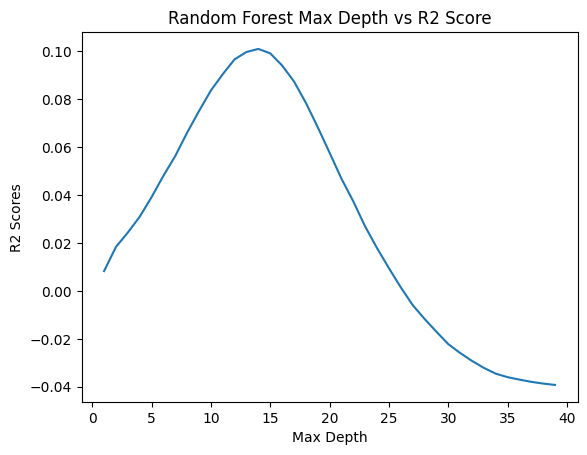

Best depth occurs at 14 with R^2 score of 0.10093972740739754


In [20]:
# Depth

kf = KFold(n_splits=5, shuffle=True, random_state=random_state)
depth_range = range(1,40)
rsts = []
best_depth = 0
best_r2 = 0

for depth in depth_range:
  rf_depth_model = RandomForestRegressor(n_estimators=best_num_trees, max_depth=depth, random_state=random_state, n_jobs=-1)
  score = cross_val_score(rf_depth_model, X_train_scaled, y_train, cv=kf, scoring='r2', n_jobs=-1)
  rsts.append((depth, score.mean()))
  best_so_far = max(rsts, key = lambda rst: rst[1])
  best_depth = best_so_far[0]
  best_r2 = best_so_far[1]

r2_scores = [x[1] for x in rsts]
depths = [x[0] for x in rsts]
plt.plot(depths, r2_scores)
plt.xlabel('Max Depth')
plt.ylabel('R2 Scores')
plt.title('Random Forest Max Depth vs R2 Score')
plt.show()

print(f'Best depth occurs at {best_depth} with R^2 score of {best_r2}')

After tuning the hyperparameters `n_estimators` and `max_depth`, we discovered that we achieved the highest $R^2$ with 186 trees and at a max depth of 14. We were able to improve the model's performance seeing as how our $R^2$ is now positive albeit low.

Since our $R^2$ became positive after adjusting our max_depth, it is likely that the negative $R^2$ we observed before was due to **overfitting**.

#### **Testing the model**

We'll now evaluate our model by comparing our prediction on the test dataset and the actual results.

In [21]:
# Training model
RF_model = RandomForestRegressor(n_estimators=best_num_trees, max_depth=best_depth, random_state=random_state)
RF_model.fit(X_train_scaled, y_train)
y_pred = RF_model.predict(X_test_scaled)
accuracy = r2_score(y_test, y_pred)
print(f'R2 score: {accuracy:.2f}')

R2 score: 0.10


Based on the results, we got an $R^2$ of 0.1, similar what we got after our hyperparameter tuning. Since we got a low $R^2$, this indicates that our model does a poor job in highlighting a relationship between a player's biometric and their scoring capability.

Let's observe how much importance our model gave for each biometric feature in determining a player's scoring capability through feature importance (https://www.geeksforgeeks.org/feature-importance-with-random-forests/)

In [22]:
importances = RF_model.feature_importances_
feature_importance_df = pd.DataFrame({'Columns': X_train_scaled.columns, 'Feature Importances': importances})
feature_importance_df

print('Ranked by Features (according to our Random Forest)')
feature_importance_df.sort_values('Feature Importances', ascending=False).set_index('Columns')

Ranked by Features (according to our Random Forest)


,Feature Importances
Columns,
player_weight_lb,0.383815
player_height_ft,0.240639
age,0.200159
country_Germany,0.018766
country_USA,0.018542
country_Other,0.014142
country_Greece,0.012077
country_Canada,0.011877
country_Spain,0.011613


It seems that our model places the most importance:
1. Weight
2. Height
3. Age
4. Country of Origin

We should keep into consideration that these rankings are based on a low $R^2$ model's interpretation, so take it with a grain of salt.

# **Visualization**

Let's take a closer look at the relationship between the biometric features and player's average points using a correlation matrix (https://www.investopedia.com/terms/c/correlationcoefficient.asp) to see whether a poor relationship is behind our model's performance.

<Figure size 800x600 with 0 Axes>

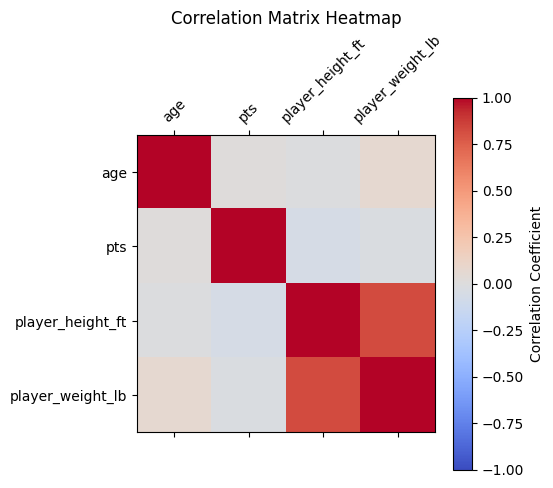

                       age       pts  player_height_ft  player_weight_lb
age               1.000000  0.011353         -0.007950          0.063559
pts               0.011353  1.000000         -0.055424         -0.025033
player_height_ft -0.007950 -0.055424          1.000000          0.822010
player_weight_lb  0.063559 -0.025033          0.822010          1.000000


,pts
pts,1.000000
age,0.011353
player_weight_lb,-0.025033
player_height_ft,-0.055424


In [48]:
corr = nba_players.drop(columns=[col for col in nba_players.columns if col not in ['player_height_ft', 'player_weight_lb', 'age', 'pts']])
correlation_matrix = corr.corr()

plt.figure(figsize=(8, 6))
cax = plt.matshow(correlation_matrix, cmap='coolwarm', vmin=-1, vmax=1, interpolation='none', aspect='equal')
plt.colorbar(cax, label='Correlation Coefficient')
plt.xticks(range(len(correlation_matrix.columns)), correlation_matrix.columns, rotation=45, fontsize=10)
plt.yticks(range(len(correlation_matrix.index)), correlation_matrix.index, fontsize=10)
plt.title('Correlation Matrix Heatmap')
plt.show()
print(correlation_matrix)

correlation_matrix['pts'].sort_values(ascending=False)

It seems that the reasoning behind our random forest's performance was due to each biometric feature having little to no correlation to points within the dataset!

### **Linear Regression**

To analyze the impact of each biometric feature on scoring performance independently, we will use Linear Regression models for each feature (height, weight, age, and country). This allows us to evaluate how each feature contributes individually to predicting scoring performance. We will view how our model compares to the expected results (red line).


 Analyzing Feature: player_height_ft 


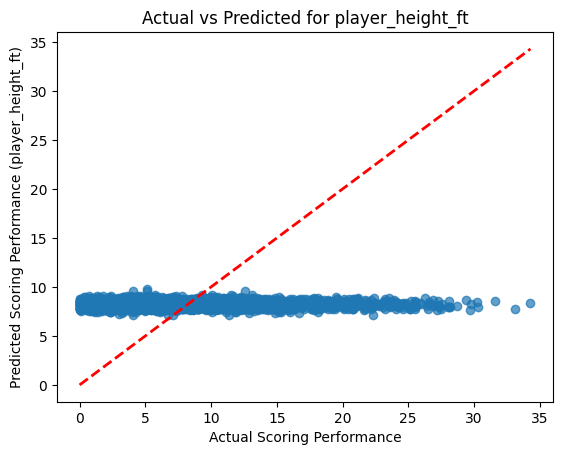


 Analyzing Feature: player_weight_lb 


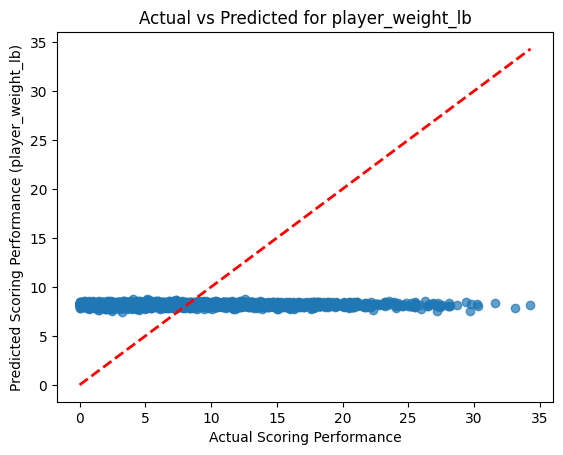


 Analyzing Feature: age 


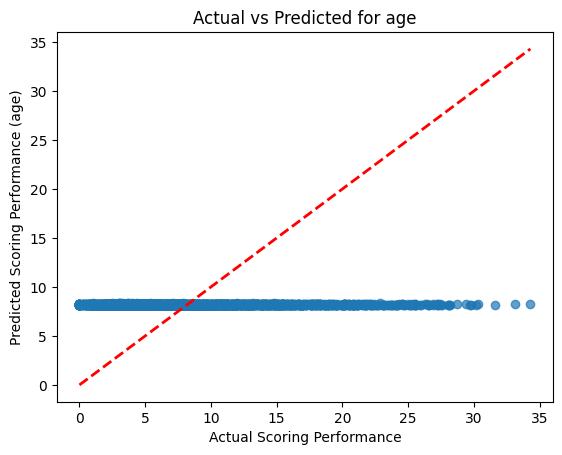


 Analyzing Feature: country 


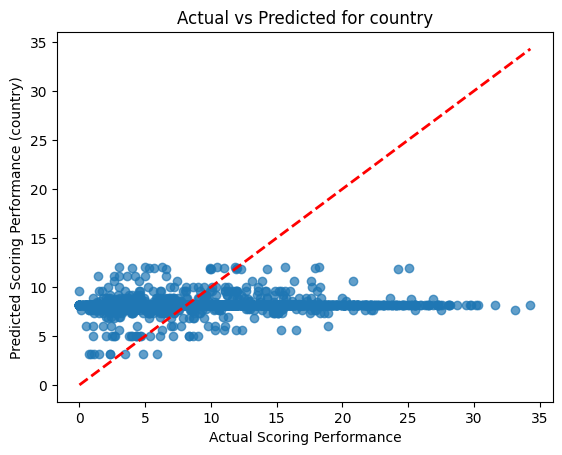

             Feature  Train R^2  Test R^2  Train MSE   Test MSE
0   player_height_ft   0.003377  0.001638  35.963118  36.575834
1   player_weight_lb   0.000864 -0.000602  36.053802  36.657871
2                age   0.000056  0.000141  36.082965  36.630679
3   player_height_ft   0.003377  0.001638  35.963118  36.575834
4   player_weight_lb   0.000864 -0.000602  36.053802  36.657871
5                age   0.000056  0.000141  36.082965  36.630679
6            country   0.012750  0.006279  35.624900  36.405779
7   player_height_ft   0.003377  0.001638  35.963118  36.575834
8   player_weight_lb   0.000864 -0.000602  36.053802  36.657871
9                age   0.000056  0.000141  36.082965  36.630679
10           country   0.012750  0.006279  35.624900  36.405779


In [45]:
# Updated code to analyze features
for feature in features:
    print(f"\n Analyzing Feature: {feature} ")
    
    # Handle categorical data for 'country'
    if feature == 'country':
        # Dynamically collect all one-hot encoded country columns
        country_columns = [col for col in X_nba_players.columns if col.startswith('country_')]
        X_feature = X_nba_players[country_columns]
    else:
        X_feature = X_nba_players[[feature]]
    
    # Train-test split
    X_train_feat, X_test_feat, y_train_feat, y_test_feat = train_test_split(
        X_feature, Y_nba_players, test_size=0.2, random_state=42
    )
    
    # Train linear regression model
    model = LinearRegression()
    model.fit(X_train_feat, y_train_feat)
    
    # Predictions
    y_train_pred = model.predict(X_train_feat)
    y_test_pred = model.predict(X_test_feat)
    
    # Evaluation Metrics
    train_r2 = r2_score(y_train_feat, y_train_pred)
    test_r2 = r2_score(y_test_feat, y_test_pred)
    train_mse = mean_squared_error(y_train_feat, y_train_pred)
    test_mse = mean_squared_error(y_test_feat, y_test_pred)
    
    # Save results
    results.append({
        'Feature': feature,
        'Train R^2': train_r2,
        'Test R^2': test_r2,
        'Train MSE': train_mse,
        'Test MSE': test_mse
    })
    
    # Visualization
    plt.scatter(y_test_feat, y_test_pred, alpha=0.7)
    plt.xlabel("Actual Scoring Performance")
    plt.ylabel(f"Predicted Scoring Performance ({feature})")
    plt.title(f"Actual vs Predicted for {feature}")
    plt.plot([y_test_feat.min(), y_test_feat.max()], [y_test_feat.min(), y_test_feat.max()], 'r--', lw=2)
    plt.show()

# Display Results
results_df = pd.DataFrame(results)
print(results_df)

# **Insights and Conclusions**

### Explanation/Summary of Results
1) Feature-Specific Models:
    * A separate regression model is trained for each feature to isolate its impact.
    * For the categorical country feature, one-hot encoding is applied before training the model.
2) Train-Test Split:
    * Ensures consistency in splitting the data for each feature.
3) Evaluation Metrics:
    * $R^2$ : Measures how well the feature explains variability in scoring performance.
    * MSE: Indicates the average error in predictions.
4) Visualization:
    * Scatter plots show the relationship between actual and predicted scoring performance for each feature.
5) Reuslts: 
    * The $R^2$ values provide a clear indication of how well each feature explains scoring performance:
      * A $R^2$ higher suggests the feature has a strong impact.
      * A $R^2$ lower suggests the feature has limited predictive ability.
6) Comparison of MSE across features shows which feature leads to the least error in predictions.

### Overall Conclusion
This analysis highlights the relative importance of each biometric feature for predicting scoring performance. Features with low $R^2$ may not have significant individual predictive power but could still contribute to a model when combined with other features. Let me know if you'd like further refinements or insights!